## Практическая часть

In [1]:
import numpy as np
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


from collections import defaultdict
from functools import partial
from itertools import chain
import re
import string
from tqdm.notebook import tqdm

from IPython.display import display, clear_output


from filimdb_evaluation.score import load_dataset_fast

In [2]:
all_data = load_dataset_fast()

Loading train set 
pos 7520
neg 7480
Loading dev set 
pos 4980
neg 5020
Loading test set 
unlabeled 25000


In [3]:
train_dataset = all_data['train']
dev_dataset = all_data['dev']
test_dataset = all_data['test']

### 1. Сделайте предобработку документов по аналогии с предыдущими заданиями

In [4]:
def preprocessing(text):
    text = text.lower()
    remove_tags = re.compile(r'<.*?>')
    text = re.sub(remove_tags, '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join(sym if (sym.isalnum() or sym in (" ", "'")) else f" {sym} " for sym in text)
    return text

In [5]:
def tokenize_text(text, stem=0):
    """
        arg: list of texts
        return: list of tokenized texts
    """
    stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', \
    'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with',
     'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'could','couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    tokenizer = re.compile(r"-?\d*[.,]?\d+|[?'\w]+|\S", re.MULTILINE | re.IGNORECASE)
    tokenized_text = tokenizer.findall(text)
    if stem == 0:
        return [token for token in tokenized_text if token not in stop_words]
    stem_dataset = [token[:stem] for token in tokenized_text if token not in stop_words]
    return stem_dataset

In [6]:
def preprocess_dataset(dataset):
    processed_dataset = []
    is_test = False
    if dataset[2] is None:
        dataset = dataset[:2]
        is_test = True
    for ind, ds_data in enumerate(zip(*dataset)):
        prepared_text = preprocessing(ds_data[1])
        tokenized_text = tokenize_text(prepared_text)
        if not is_test:
            processed_dataset.append((tokenized_text, ds_data[2]))
        else:
            processed_dataset.append(tokenized_text)
    return processed_dataset

In [7]:
train_dataset = preprocess_dataset(train_dataset)
dev_dataset = preprocess_dataset(dev_dataset)
test_dataset = preprocess_dataset(test_dataset)

In [8]:
print(train_dataset[0])

(['myth', 'regarding', 'broken', 'mirrors', 'would', 'accurate', 'everybody', 'involved', 'production', 'would', 'face', 'approximately', '170', 'years', 'bad', 'luck', 'lot', 'mirrors', 'falling', 'little', 'pieces', 'script', 'shattering', 'glass', 'broken', 'would', 'brilliant', 'film', 'sadly', 'overlong', 'derivative', 'dull', 'movie', 'handful', 'remarkable', 'ideas', 'memorable', 'sequences', 'sean', 'ellis', 'made', 'stylish', 'elegantly', 'photographed', 'movie', 'story', 'lackluster', 'total', 'absence', 'logic', 'explanation', 'really', 'frustrating', 'got', 'discussion', 'friend', 'regarding', 'basic', 'concept', 'meaning', 'film', 'thinks', 'ellis', 'found', 'inspiration', 'old', 'legend', 'claiming', 'spotting', 'doppelganger', 'foreboding', 'youre', 'going', 'die', 'interesting', 'theory', 'im', 'familiar', 'legend', 'couldnt', 'find', 'anything', 'internet', 'neither', 'personally', 'think', 'broken', 'yet', 'another', 'umpteenth', 'variation', 'theme', 'invasion', 'bod

### 2. Замените каждый документ на набор униграмм, биграмм и триграмм, которые в нём встречаются (каждая n-грамма входит в набор столько раз, сколько раз встречается в тексте).

In [9]:
def generate_ngrams(text, max_ngram=3):
    ngrams = []
    for token in text:
        ngrams.append(token)
    if max_ngram >= 2:
        for token in zip(text[:-1], text[1:]):
            ngrams.append(token)
    if max_ngram >= 3:
        for token in zip(text[:-2], text[1:-1], text[2:]):
            ngrams.append(token)
    return ngrams

In [10]:
def make_ngram_dataset(dataset, max_ngram=3):
    ngram_dataset = []
    for ind, ds_info in enumerate(dataset):
        ngrams = generate_ngrams(ds_info[0])
        ngram_dataset.append((ngrams, *ds_info[1:]))
    return ngram_dataset

In [11]:
train_dataset = make_ngram_dataset(train_dataset)
dev_dataset = make_ngram_dataset(dev_dataset)
test_dataset = make_ngram_dataset(test_dataset)

In [12]:
train_dataset[0]

(['myth',
  'regarding',
  'broken',
  'mirrors',
  'would',
  'accurate',
  'everybody',
  'involved',
  'production',
  'would',
  'face',
  'approximately',
  '170',
  'years',
  'bad',
  'luck',
  'lot',
  'mirrors',
  'falling',
  'little',
  'pieces',
  'script',
  'shattering',
  'glass',
  'broken',
  'would',
  'brilliant',
  'film',
  'sadly',
  'overlong',
  'derivative',
  'dull',
  'movie',
  'handful',
  'remarkable',
  'ideas',
  'memorable',
  'sequences',
  'sean',
  'ellis',
  'made',
  'stylish',
  'elegantly',
  'photographed',
  'movie',
  'story',
  'lackluster',
  'total',
  'absence',
  'logic',
  'explanation',
  'really',
  'frustrating',
  'got',
  'discussion',
  'friend',
  'regarding',
  'basic',
  'concept',
  'meaning',
  'film',
  'thinks',
  'ellis',
  'found',
  'inspiration',
  'old',
  'legend',
  'claiming',
  'spotting',
  'doppelganger',
  'foreboding',
  'youre',
  'going',
  'die',
  'interesting',
  'theory',
  'im',
  'familiar',
  'legend',


### 3. Создайте словарь из индексов n-грамм и посчитайте кол-во вхождений в корпус каждой n-граммы. Сделайте отсечку по частоте встречаемости в корпусе, так чтобы осталось около миллиона элементов.

In [13]:
def make_vocab(datasets, max_df = 0.5, min_df = 10, min_tf = 3, max_tokens = 1000000):
    df_cnt = defaultdict(int)
    tf_cnt = defaultdict(int)
    total_documents = sum(len(ds) for ds in datasets)
    for ds in datasets:
        for ds_info in ds:
            been = set()
            for token in ds_info[0]:
                if  token not in been:
                    been.add(token)
                    df_cnt[token] += 1
                tf_cnt[token] += 1
                
    free_ind = 0
    w2ind = dict()
    vocab_tf = []
    tf_with_inds = []
    for word, tf in tf_cnt.items():
        df = df_cnt[word]
        if tf >= min_tf and df / total_documents <= max_df and df >= min_df:
            w2ind[word] = free_ind
            vocab_tf.append(tf)
            tf_with_inds.append((tf, word))
            free_ind += 1
            
    tf_with_inds.sort(key=lambda x:x[0], reverse=True)
    for tf, w in tf_with_inds[max_tokens:]:
        del w2ind[w]
    
    free_ind = 0
    w2ind_final = dict()
    vocab_tf_final = []
    for w, ind in w2ind.items():
        w2ind_final[w] = free_ind
        vocab_tf_final.append(tf_cnt[w])
        free_ind += 1
        
    return w2ind_final, vocab_tf_final

In [14]:
w2ind_full, vocab_tf_full = make_vocab([train_dataset, dev_dataset, test_dataset], min_tf=1, max_df=1.0, min_df=1, max_tokens=5000000)

In [15]:
print(len(w2ind_full))

4851187


Построим гистограмму встречаемости слов в словаре без изменений.

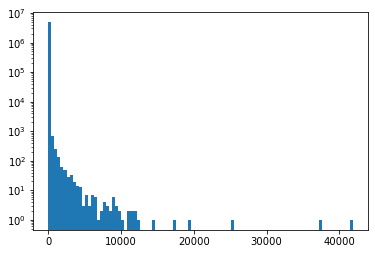

In [16]:
plt.hist(vocab_tf_full, log=True, bins=100)
plt.show()

Здесь не очень видно, но очень много токенов встречается в корпусе 1 раз.
<br>
Такое очень сложно как-то ограничить частотами до миллиона, поэтому просто отсортируем все слова по частоте встречаемости и оставим с наибольшими частотами миллион токенов. 

In [17]:
w2ind, vocab_tf = make_vocab([train_dataset, dev_dataset, test_dataset], min_tf=1, max_df=0.7, min_df=1, max_tokens=1000000)

In [18]:
print(len(w2ind))

1000000


Теперь нормас.

### 4. Возведите количество вхождений в корпусе каждой n-граммы в степень 3/4. А затем нормализуйте так, чтобы получились вероятности.

In [19]:
vocab_tf = np.array(vocab_tf, dtype=np.float64)
vocab_tf_prob = np.float_power(vocab_tf, 0.75)
vocab_tf_prob /= vocab_tf_prob.sum()

In [20]:
vocab_tf_prob.sum()

1.0000000000000002

### 5. Все документы представьте в виде двух массивов данных одинакового размера: в первый массив сохраните все индексы n-грамм для всех документов, во второй массив — индексы документов для соответствующих n-грамм в первом массиве. 

Склеим все датасеты в один для обучения эмбеддингов документов

In [21]:
transductive_dataset = list(chain(train_dataset, dev_dataset, test_dataset))
print(len(transductive_dataset))

50000


In [22]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))

15000 10000 25000


In [23]:
transductive_texts = [x[0] for x in transductive_dataset]
print(len(transductive_texts))

50000


In [24]:
def make_inds_ngram_dataset(texts, w2ind, shuffle=True):
    ngrams_inds = []
    docs_inds = []
    for doc_ind, text in enumerate(texts):
        for ngram in text:
            if ngram in w2ind:
                ngrams_inds.append(w2ind[ngram])
                docs_inds.append(doc_ind)
            
    ngrams_inds = np.array(ngrams_inds)
    docs_inds = np.array(docs_inds)
    assert(len(ngrams_inds) == len(docs_inds))
    if shuffle:
        permutation = np.random.permutation(len(docs_inds))
        ngrams_inds = ngrams_inds[permutation]
        docs_inds = docs_inds[permutation]
    return ngrams_inds, docs_inds

In [25]:
transductive_inds_dataset = make_inds_ngram_dataset(transductive_texts, w2ind, shuffle=True)

In [26]:
print(len(transductive_inds_dataset[0]))
print(len(transductive_inds_dataset[1]))

5494618
5494618


### 6. Напишите функцию batch_generator

In [27]:
def batch_generator(words_idxs, docs_idxs, probs, nb=5, batch_size=100):
    # Let's generate all negative examples at once.
    
    neg_samples = np.random.choice(np.arange(len(probs)), size = (nb * len(words_idxs), ), p=probs)
    
#     print("pos_samples_len = ", len(docs_idxs), ", neg_samples = ", len(neg_samples))
    
    end = (len(words_idxs) // batch_size - 1) * batch_size + 1
    for batch_start in range(0, end, batch_size):
        pos_batch = words_idxs[batch_start : batch_start + batch_size]
        docs_batch = docs_idxs[batch_start : batch_start + batch_size]
        pos_labels_batch = np.array([1 for _ in range(len(pos_batch))])
        yield (pos_batch, docs_batch, pos_labels_batch)
        for i in range(nb):
            neg_batch = neg_samples[batch_start + batch_size * i : batch_start + batch_size * (i + 1)]
            neg_labels_batch = np.array([0 for _ in range(len(neg_batch))])
            yield (neg_batch, docs_batch, neg_labels_batch)

In [28]:
test_bg = batch_generator(transductive_inds_dataset[0], transductive_inds_dataset[1], vocab_tf_prob, batch_size=5)

In [29]:
next(test_bg)

(array([444905, 318999,  50459, 195750,    722]),
 array([13451, 22374,   178,   750, 13147]),
 array([1, 1, 1, 1, 1]))

In [30]:
next(test_bg)

(array([932707,  68086,  74010,   1352,  37643]),
 array([13451, 22374,   178,   750, 13147]),
 array([0, 0, 0, 0, 0]))

### 7. Далее создадим класс Doc2Vec,

In [31]:
class Doc2Vec:
    def __init__(self, vocab_size, docs_cnt, emb_size=500, train_start = 0):
        self.word_embs = np.random.uniform(low=-0.001, high=0.001, size=(vocab_size, emb_size))
        self.docs_embs = np.random.uniform(low=-0.001, high=0.001, size=(docs_cnt, emb_size))
        self.vocab_size = vocab_size
        self.docs_cnt = docs_cnt
        self.emb_size = emb_size
        self.train_start = train_start
    
    def train(self, word_inds, doc_inds, labels, lr):
        word_batch_embs = self.word_embs[word_inds]
        doc_batch_embs = self.docs_embs[doc_inds]
        
        dot_prods = np.einsum('ij,ij->i', word_batch_embs, doc_batch_embs)
        y_pred = self.sigmoid(dot_prods)
        
        word_batch_grads = doc_batch_embs * (y_pred - labels).reshape(-1, 1)
        doc_batch_grads = word_batch_embs * (y_pred - labels).reshape(-1, 1)
        
        for ind, (w_ind, d_ind) in enumerate(zip(word_inds, doc_inds)):
            self.word_embs[w_ind] -= lr * word_batch_grads[ind]
            self.docs_embs[d_ind] -= lr * doc_batch_grads[ind]
    
        batch_loss = (-labels * np.log(y_pred) - (1 - labels) * np.log(1 - y_pred)).sum()
        
        return batch_loss
            
    def get_all_X(self):
        train_borders = (self.train_start, self.train_start + 15000)
        dev_borders = (train_borders[1], train_borders[1] + 10000)
        test_borders = (dev_borders[1], dev_borders[1] + 25000)
        X_train = self.docs_embs[train_borders[0] : train_borders[1]]
        X_dev = self.docs_embs[dev_borders[0] : dev_borders[1]]
        X_test = self.docs_embs[test_borders[0] : test_borders[1]]
    
        return X_train, X_dev, X_test
    
    def sigmoid(self, x):
        return np.where(x > 0, 1.0 / (1.0 + np.exp(-x)), np.exp(x) / (np.exp(x) + 1.0))

### 9. Напишите функцию, которая будет принимать эмбединги и метки документов из train и dev выборок, обучать логистическую регрессию на обучающей и возвращать ее точность на обучающей и валидационной выборках.

In [43]:
def train_logreg(X_train, y_train, X_dev, y_dev):
    model = LogisticRegression(penalty='l2', max_iter=500)
    
    log_border = 3
    C_values = np.logspace(-log_border, log_border, 30)
    params = {'C' : C_values}
    gs_clf = GridSearchCV(model, params, cv=10, n_jobs=4, verbose=1)
    gs_clf.fit(X_train, y_train)
    
    if gs_clf.best_params_['C'] in (C_values[0], C_values[-1]):
        print("C is on border!")
        log_border += 2
        C_values = np.logspace(-log_border, log_border, 30)
        params = {'C' : C_values}
        gs_clf = GridSearchCV(model, params, cv=10, n_jobs=4, verbose=1)
        gs_clf.fit(X_train, y_train)
    
    train_acc = gs_clf.best_score_
    
    best_model = gs_clf.best_estimator_
    dev_acc = best_model.score(X_dev, y_dev)
    return train_acc, dev_acc

### 10. Напишите цикл обучения модели по эпохам.


Соберем все данные, что у нас есть

In [33]:
# Тексты для обучения doc2vec
transductive_inds_dataset
# Ещё нужны лейблы для обучения логистической регрессии.
train_labels = np.array([int(lab == 'pos') for text, lab in train_dataset], dtype=np.int32)
print(train_labels, len(train_labels))

dev_labels = np.array([int(lab == 'pos') for text, lab in dev_dataset], dtype=np.int32)
print(dev_labels, len(dev_labels))

[0 1 0 ... 0 1 1] 15000
[0 0 1 ... 1 1 0] 10000


In [44]:
def fit(doc2vec_model, d2v_data, vocab_probs, train_labels, dev_labels, num_epochs, doc2vec_lr):
    train_accs = []
    dev_accs = []
    
    
    d2v_nb = 5
    d2v_batch_size = 100
    
    total_epoch_iterations = ((d2v_nb + 1) * len(d2v_data[0])) // d2v_batch_size
    
    total_iter = num_epochs * total_epoch_iterations
    
    loss_stat_border = 150000
    cur_iter = 0
    for ep in range(num_epochs):
        print("Start epoch #", ep + 1)
        print("Training Doc2Vec")
        batch_gen = batch_generator(*d2v_data, probs=vocab_probs)
        avg_loss = 0.0
        for ind, (word_inds, doc_inds, labels) in enumerate(tqdm(batch_gen)):
            new_lr = doc2vec_lr * (1 - cur_iter * 1.0 / total_iter)
            batch_loss = doc2vec.train(word_inds, doc_inds, labels, new_lr)
            cur_iter += 1
            avg_loss += batch_loss
            if ind % loss_stat_border == 0 and ind != 0:
                tqdm.write(f"avg_loss: {avg_loss / loss_stat_border}")
                avg_loss = 0.0
            
        print("Starting logistic regression")
        
        X_train, X_dev, X_test = doc2vec_model.get_all_X()
        
        t_acc, d_acc = train_logreg(X_train, train_labels, X_dev, dev_labels)
        print("Train acc = ", t_acc, " Dev acc =  ", d_acc)
        train_accs.append(t_acc)
        dev_accs.append(d_acc)
    return train_accs, dev_accs

In [45]:
doc2vec = Doc2Vec(len(w2ind), len(transductive_dataset))

In [46]:
accs = fit(doc2vec, transductive_inds_dataset, vocab_tf_prob, train_labels, dev_labels, num_epochs=10, doc2vec_lr=0.025)

Start epoch # 1
Training Doc2Vec


avg_loss: 69.31516603481327
avg_loss: 69.30763717463344

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.1min finished


Train acc =  0.5916666666666667  Dev acc =   0.5997
Start epoch # 2
Training Doc2Vec


avg_loss: 68.07554473198431
avg_loss: 63.77839805013095

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  3.6min finished


Train acc =  0.7155333333333334  Dev acc =   0.7169
Start epoch # 3
Training Doc2Vec


avg_loss: 57.49392091619331
avg_loss: 53.13841046058573

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  7.0min finished
/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


C is on border!
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  8.5min finished


Train acc =  0.7654  Dev acc =   0.7656
Start epoch # 4
Training Doc2Vec


/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


avg_loss: 49.60746387181563
avg_loss: 47.64303773843465

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  9.0min finished
/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


C is on border!
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 10.0min finished


Train acc =  0.7950666666666667  Dev acc =   0.7926
Start epoch # 5
Training Doc2Vec


/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


avg_loss: 46.103554312859046
avg_loss: 45.14614320294521

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 10.6min finished


Train acc =  0.8174666666666667  Dev acc =   0.8148
Start epoch # 6
Training Doc2Vec


/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


avg_loss: 44.32933396087691
avg_loss: 43.734775207944786

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 12.5min finished


Train acc =  0.8318666666666668  Dev acc =   0.8307
Start epoch # 7
Training Doc2Vec


/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


avg_loss: 43.205131392386974
avg_loss: 42.779361674851174

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 12.7min finished


Train acc =  0.8398  Dev acc =   0.8411
Start epoch # 8
Training Doc2Vec


/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


avg_loss: 42.39308073389108
avg_loss: 42.095640188898116

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 11.3min finished


Train acc =  0.8447333333333333  Dev acc =   0.8456
Start epoch # 9
Training Doc2Vec


/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


avg_loss: 41.813451444511806
avg_loss: 41.602516138933524

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 10.0min finished


Train acc =  0.8482  Dev acc =   0.8479
Start epoch # 10
Training Doc2Vec


/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


avg_loss: 41.44936494621847
avg_loss: 41.34247249289598

Starting logistic regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 10.1min finished


Train acc =  0.8487333333333332  Dev acc =   0.8494


/home/rmnnsk/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


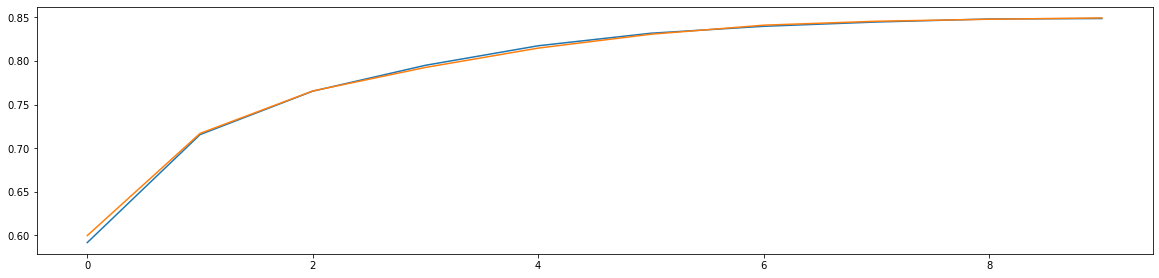

In [51]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)
ax1.plot(range(10), accs[0])
ax1.plot(range(10), accs[1])

Видно, что точность на тренировочном и валидационном датасетах растёт одинаково и упирается в 85%.<br>
Это говорит о том, что модель не переобучается и если добавить в неё побольше данных, то можно выбить больше точности (так и оказалось).

### 11.  Опишите, какие гиперпараметры модели и каким образом подбирались? Какая получилась итоговая точность на train/dev/test выборках? Как зависит точность от значения гиперпараметров?

Подбирались:
<br><br>
**1. Размер эмбеддинга из нескольких значений: [100, 300, 500]**
<br>
Из опыта предыдущего семестра было взято значение 500, т.к. классификатор с GloVe векторами давал наилучшие показатели именно с 500-мерными эмбедингами. 
Ну и плюс к этому обучать остальные модели было бы так же долго, а т.к. это было почти сразу обречено на провал, то было принятно решение этого не делать.
<br><br>
**2. learning_rate и количество эпох для обучения модели Doc2Vec**
<br>
Изначально, прочитав статью, я поставил **lr = 0.25** и градиенты взрывались на середине 1 эпохи.<br>
Уменьшил до **lr = 0.15** и градиенты стали взрываться на второй эпохе (невероятно).<br>

Потом я прочитал код на гитхабе, который прилагался к статье и оказалось, что там **lr=0.025**. (спасибо за счастливые 3-4 часа отладки правильного кода)<br>

Но даже после этого градиенты взрывались на 10 эпохе и было принято решение сделать уменьшение лёрнинг рейта по мере обучения.<br>
***Пока это линейное уменьшение от 0.03 до 0 на каждом шаге градиентного спуска.***
<br><br>
**3. Параметры для GridSearchCV:**
<br>
    Тут всё подбирается так, чтобы после обучения векторов документов наша линейная регрессия сходилась и делала это не за миллион лет.<br>
    
   **3.1. Количество различных С.**
    <br>
    Тут подбираем по количеству свободного времени. Я поставил от $10^{-3}$ до $10^3$ и $30$ различных значений.<br>
    Такая большая граница сверху, чтобы С точно никогда не было на границе. И так и происходит. Но если будет на границе, то мы их увеличиваем и запускаем GridSearch ещё раз.
    <br><br>
    **3.2. Количество итераций логистической регрессии.**
    <br>
        Тут я столкнулся с проблемой, что на 50-100 итерациях регрессия не успевает сходиться. <br>
        Поэтому приходится увеличивать их количество. В этом ноутбуке это 200-300 итераций, т.к. тут **GridSearch** запускается после каждой эпохи. В скрипте классификатора это 1000 итераций, т.к. запускается один раз и нужно, чтобы точно сошлось
<br><br>

**4.Параметры словаря: максимальные и минимальные частоты встречаемости, максимальный размер словаря.**
<br>
Тут исходим из такой логики: 
1. Мы хотим, чтобы слово встречалось как минимум в двух документах, потому что иначе оно не придаст никакого смысла модели (т.к. иначе это может быть любое рандомное слово).
2. Мы хотим, чтобы слово встречалось в корпусе минимум 2-3 раза, чтобы отфильтровать опечатки.
3. Мы хотим, чтобы остались триграммы, ведь они дают очень много смысла, но очень редко встречаются. Поэтому нужно аккуратнее ставить границы.
4. Мы не хотим вечность ждать обучения.
5. У нас ограниченный(хоть и большой) объем памяти.
<br><br>
**Из всего этого мы получаем следующие ограничения:**
<br>
Для ноутбука (тут нет unlabeled текстов и маленьких текстов): $min\_tf=1, min\_df=1, max\_df=0.7, max\_tokens=10^6$
<br>
**Всего $10^6$ уникальных токенов.**
<br><br>
Для оценивающего скрипта: $min\_tf=3, min\_df=3, max\_df=0.5, max\_tokens=2 * 10^6$
<br>
**Всего $1.5 * 10^6$ уникальных токенов.**

### 12. Вопрос. Какие трудности возникли при выполнения задания?

1. Основная трудность в ожидании обучения. Это сильно затягивает исправление возможных ошибок и замедляет разработку новых фичей.

2. Не очень информативная основная статья С ОПЕЧАТКАМИ. Но это компенсируется реально подробным заданием.

3. Ещё хотелось бы знать хотя бы примерную желаемую скорость работы, чтобы было на что ориентироваться при написании и когда можно остановиться.

Дальше попробуем улучшить точность в **research** части.